# Imports

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import math
from tqdm.notebook import tqdm
import iteration_utilities
import statsmodels
import scipy.optimize
import scipy.spatial.distance as sd
from lmfit import *
from matplotlib.lines import Line2D

mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['pdf.fonttype'] = 42
sns.set_style(
    'ticks',
    {
        'xtick.major.size': 4,
        'ytick.major.size': 4,
        'font_color': 'k',
        'axes.edgecolor': 'k',
        'xtick.color': 'k',
        'ytick.color': 'k',
    },
)
sns.set_context('talk', font_scale=1.0)

# Loading Parameter Data

In [23]:
df = pd.read_csv("./popt_df.csv")
dq = df[df['date']=='2022-08-24']
dq

,plasmid,date,description,bprime,lambda,sigma_on,sigma_off,mu_off
17,79,2022-08-24,ANM2 - KIBRA,0.517093,1312.201696,0.384008,0.544797,7.500000
20,80,2022-08-24,BIN1 - FOXO3,0.542960,757.491897,0.483716,0.262398,6.399699
30,91,2022-08-24,NOTC2 - KIBRA,0.271424,81.767887,0.661647,0.171190,6.297044
48,134,2022-08-24,MYBA - ZN473,0.497006,379.002749,0.736880,0.233467,6.353125
57,192,2022-08-24,ANM2 - Rand124,0.196615,0.000010,0.228229,0.127831,6.310536
58,193,2022-08-24,Rand124 - KIBRA,0.563406,342.088506,0.416884,0.160201,6.344104
59,194,2022-08-24,NOTC2 - Rand124,0.103550,0.000010,0.305751,0.131516,6.301543
60,196,2022-08-24,ANM2 - NOTC2,0.747186,1056.631571,0.773036,0.324850,6.507078
61,198,2022-08-24,MYBA - Rand124,0.707112,947.283207,0.345120,0.668387,7.043549
62,199,2022-08-24,Rand124 - ZN473,0.437019,937.453641,0.330032,0.502408,6.811619


In [49]:
def get_d1_info(d):
    d1 = d.split(" - ")[0]
    dd = dq[dq["description"].str.contains(d1) & dq["description"].str.contains("Rand124")]
    dd = dd.add_prefix("d1_")
    dd["description"] = d
    
    return dd

def get_d2_info(d):
    d1 = d.split(" - ")[1]
    dd = dq[dq["description"].str.contains(d1) & dq["description"].str.contains("Rand124")]
    dd = dd.add_prefix("d2_")
    dd["description"] = d
    return dd

In [52]:
dp = dq[~dq["description"].str.contains("Rand124")]
df1 = pd.concat([get_d1_info(d) for d in list(dp["description"])])
df2 = pd.concat([get_d2_info(d) for d in list(dp["description"])])
dp = (
    dp.set_index("description")
    .join(df1.set_index("description"), how="left")
    .join(df2.set_index("description"), how="left")
    .reset_index()
)
dp["sum_bprime"] = dp["d1_bprime"] + dp["d2_bprime"]
dp["sum_lambda"] = dp["d1_lambda"] + dp["d2_lambda"]
dp

,description,plasmid,date,bprime,lambda,sigma_on,sigma_off,mu_off,d1_plasmid,d1_date,...,d2_plasmid,d2_date,d2_description,d2_bprime,d2_lambda,d2_sigma_on,d2_sigma_off,d2_mu_off,sum_bprime,sum_lambda
0,ANM2 - KIBRA,79,2022-08-24,0.517093,1312.201696,0.384008,0.544797,7.500000,192,2022-08-24,...,193,2022-08-24,Rand124 - KIBRA,0.563406,342.088506,0.416884,0.160201,6.344104,0.760021,342.088516
1,BIN1 - FOXO3,80,2022-08-24,0.542960,757.491897,0.483716,0.262398,6.399699,201,2022-08-24,...,202,2022-08-24,Rand124 - FOXO3,0.653036,908.886258,0.379872,0.295107,6.402294,0.675560,908.886268
2,NOTC2 - KIBRA,91,2022-08-24,0.271424,81.767887,0.661647,0.171190,6.297044,194,2022-08-24,...,193,2022-08-24,Rand124 - KIBRA,0.563406,342.088506,0.416884,0.160201,6.344104,0.666956,342.088516
3,MYBA - ZN473,134,2022-08-24,0.497006,379.002749,0.736880,0.233467,6.353125,198,2022-08-24,...,199,2022-08-24,Rand124 - ZN473,0.437019,937.453641,0.330032,0.502408,6.811619,1.144131,1884.736848
4,ANM2 - NOTC2,196,2022-08-24,0.747186,1056.631571,0.773036,0.324850,6.507078,192,2022-08-24,...,194,2022-08-24,NOTC2 - Rand124,0.103550,0.000010,0.305751,0.131516,6.301543,0.300165,0.000020


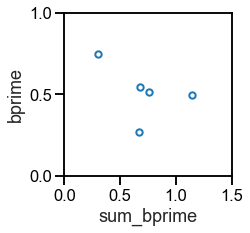

In [67]:
fig, ax = plt.subplots(figsize=(3,3))
g = sns.scatterplot(
    data = dp,
    x = "sum_bprime",
    y = "bprime",
    color="white",
    edgecolor="tab:blue",
    s=40,
    linewidth=2,
    ax=ax,
)
ax.set_xlim(0, 1.5)
ax.set_xticks([0, 0.5, 1.0, 1.5])
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.5, 1.0])

(0.0, 2000.0)

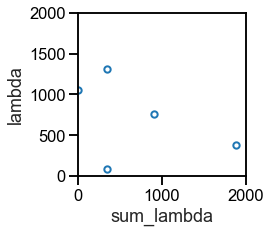

In [71]:
fig, ax = plt.subplots(figsize=(3,3))
g = sns.scatterplot(
    data = dp,
    x = "sum_lambda",
    y = "lambda",
    color="white",
    edgecolor="tab:blue",
    s=40,
    linewidth=2,
    ax=ax,
)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)